# Classification of Covid Infection Based on Chest X-Ray Images
### Table of Contents <a id="table-contents"></a>
This is the milestone 4 of the CS109B class during Spring 2024 with members Xinyu Chen, Adele Collin, Chuck Lin, Kay Wu (Group 22). 

*Note that the internal links of the table of contents work in Jupyter notebook, but VSCode and Google Colab has compatibility issues*
1. [Problem Statement](#problem_statement)
2. [EDA (exploratory data analysis)](#eda)
3. [Data Preprocessing](#data_preprocessing)
4. [Baseline Model Selection, Justification, With Results Interpretation And Analysis](#baseline_model)
5. [Final Model Pipeline Setup](final_model)

<a id="problem_statement"></a>
# 1. Problem Statement

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Reiterate and refine your problem statement. Ensure it is clear and understandable to someone outside your field.

Articulate significance based on new insights from EDA, highlighting shifts in perspective or understanding.

<a id="eda"></a>
# 2. EDA (exploratory data analysis)

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Summarize key findings from EDA, focusing on how these insights informed feature engineering and model selection.

Detail the feature engineering process, including transformations, encoding, or selection techniques, with justifications rooted in EDA.

Include visualizations that support analytical decisions, linking back to the problem statement and project goals.

In [ ]:
################################################################################
# IMPORT LIBRARIES
################################################################################
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, GaussianNoise, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax

<a id="data_preprocessing"></a>
# 3. Data Preprocessing

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Explain the choice of your baseline model, considering simplicity, interpretability, and relevance.

Detail the training process, including preprocessing, parameters, and metrics used for evaluation.

Present initial results, discussing alignment with expectations and project objectives.



Analyze the baseline model’s performance, using appropriate metrics and visualizations.

Assess strengths and weaknesses of the model, proposing improvements for the next iteration.



In [4]:
################################################################################
# LOAD THE DATA
################################################################################
##For local loading:
root = str(os.path.dirname(os.path.realpath('baseline_models.ipynb')))
root = root[1:] + '/'

br_path = '/' +os.path.join(root, "Data/Brixia/Brixia images size 224 arrays.npy")
df_brixia = np.load(br_path)

nih_path = '/' + os.path.join(root,"Data/NIHCXR/image1/NIHCXR images size 224 arrays.npy")
df_nihcxr = np.load(nih_path)

co_path_1 = '/' + os.path.join(root,"Data/COVIDGR_1.0/COVID Positive Array 224.npy")
co_path_2 = '/' + os.path.join(root,"Data/COVIDGR_1.0/COVID Negative Array 224.npy")
df_covidgr_positive = np.load(co_path_1)
df_covidgr_negative = np.load(co_path_2)


##For cloud loading:
#df_brixia = np.load("Data/Brixia/Brixia images size 224 arrays.npy")
#df_nihcxr = np.load("Data/NIHCXR/NIHCXR images size 224 arrays.npy")
#df_covidgr_positive = np.load("Data/COVIDGR_1.0/COVID Positive Array 224.npy")
#df_covidgr_negative = np.load("Data/COVIDGR_1.0/COVID Negative Array 224.npy")

In [ ]:
################################################################################
# PROCESS THE DATA
################################################################################
#Training and Validation data
X_train = np.vstack((df_brixia, df_nihcxr))
y_train = np.concatenate((np.ones(df_brixia.shape[0]), np.zeros(df_nihcxr.shape[0])))

X_test = np.vstack((df_covidgr_positive, df_covidgr_negative))
y_test = np.concatenate((np.ones(df_covidgr_positive.shape[0]), np.zeros(df_covidgr_negative.shape[0])))

<a id="baseline_model"></a>
# 4. Baseline Model Selection, Justification, With Results Interpretation And Analysis

In [42]:
################################################################################
# CNN MODELS (CREATE AND COMPILE)
################################################################################
def create_model(input_shape):
    inp = Input(shape=input_shape)
    x = GaussianNoise(stddev=0.1)(inp)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Conv2D(129, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inp], outputs=out)
    return model

def compile_and_train_model(model, optimizer, learning_rate, batch_size, X_train, y_train, epochs):
    es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[es])
    return history

In [43]:
################################################################################
# PLOTTING HELPERS
################################################################################
def plot_helper_accuracy(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['accuracy'], label='train')
    ax.plot(model.history.history['val_accuracy'], label='validation')
    best_val = np.argmax(model.history.history['val_accuracy'])
    best_val_value = np.nanmax(model.history.history['val_accuracy'])
    ax.axvline(np.argmax(model.history.history['val_accuracy']),
                    c='k', ls='--',
                    label=f'best val accuracy: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right');

def plot_helper_loss(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['loss'], label=label_train)
    ax.plot(model.history.history['val_loss'], label=label_val)
    best_val = np.argmin(model.history.history['val_loss'])
    best_val_value = np.nanmin(model.history.history['val_loss'])
    ax.axvline(np.argmin(model.history.history['val_loss']),
                    c='k', ls='--',
                    label=f'best val loss: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    ax.legend(loc='lower right');

def plot_helper_accuracy_models(history, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(history.history['accuracy'], label='train')
    ax.plot(history.history['val_accuracy'], label='validation')
    best_val = np.argmax(history.history['val_accuracy'])
    best_val_value = np.nanmax(history.history['val_accuracy'])
    ax.axvline(np.argmax(history.history['val_accuracy']),
                    c='k', ls='--',
                    label=f'best val accuracy: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right')

def plot_helper_loss_models(history, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(history.history['loss'], label=label_train)
    ax.plot(history.history['val_loss'], label=label_val)
    best_val = np.argmin(history.history['val_loss'])
    best_val_value = np.nanmin(history.history['val_loss'])
    ax.axvline(np.argmin(history.history['val_loss']),
                    c='k', ls='--',
                    label=f'best val loss: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    ax.legend(loc='upper right')

In [ ]:
################################################################################
# CNN MODELS (hyperparameter tuning: learning rate)
################################################################################
input_shape = X_train.shape[1:]

# Test learning rates
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1] 
model_list_lr = []
history_list_lr = []
for lr in learning_rates:
    model_lr = create_model(input_shape)
    history = compile_and_train_model(model_lr, tf.keras.optimizers.Adam, lr, 32, X_train, y_train, 20)
    model_list_lr.append(model_lr)
    history_list_lr.append(history)

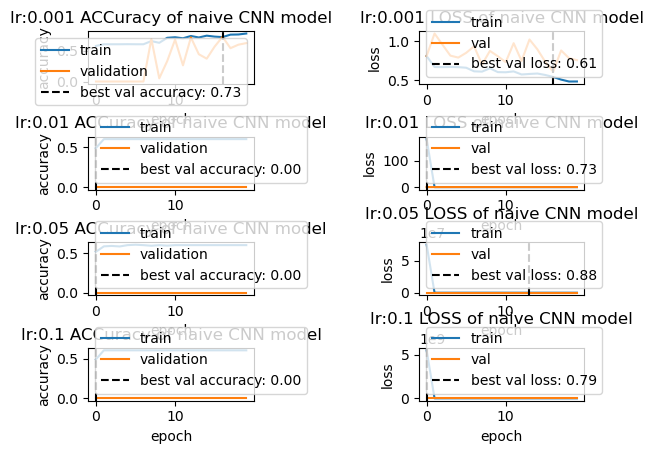

In [38]:
#Plot the results
fig, axs = plt.subplots(4, 2)
axs = axs.flatten()
for i, modl in enumerate(model_list_lr):
    plot_helper_accuracy(modl, 
                         title=f'lr:{learning_rates[i]} ACCuracy of naive CNN model', 
                         ax=axs[i*2])
    plot_helper_loss(modl, 
                     title=f'lr:{learning_rates[i]} LOSS of naive CNN model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [46]:
################################################################################
# CNN MODELS (hyperparameter tuning: batch size)
################################################################################
# Test batch sizes
batch_sizes = [32, 64, 128]
model_list_batch = []
history_list_batch = []
for batch in batch_sizes:
    model_batch = create_model(input_shape)
    history = compile_and_train_model(model_batch, tf.keras.optimizers.Adam, 0.001, batch, X_train, y_train, 10)
    model_list_batch.append(model_batch)
    history_list_batch.append(history)

Epoch 1/10


2024-04-21 08:59:12.916447: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_24/dropout_96/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 9s 239ms/step - loss: 0.6880 - accuracy: 0.5858 - val_loss: 0.9811 - val_accuracy: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 6s 221ms/step - loss: 0.6766 - accuracy: 0.6052 - val_loss: 0.8955 - val_accuracy: 0.0000e+00
Epoch 3/10
25/25 [==============================] - 6s 221ms/step - loss: 0.6755 - accuracy: 0.6052 - val_loss: 0.9594 - val_accuracy: 0.0000e+00
Epoch 4/10
25/25 [==============================] - 5s 220ms/step - loss: 0.6760 - accuracy: 0.6052 - val_loss: 0.8788 - val_accuracy: 0.0000e+00
Epoch 5/10
25/25 [==============================] - 5s 220ms/step - loss: 0.6782 - accuracy: 0.6052 - val_loss: 0.7598 - val_accuracy: 0.0000e+00
Epoch 6/10
25/25 [==============================] - 5s 219ms/step - loss: 0.6792 - accuracy: 0.6052 - val_loss: 0.9354 - val_accuracy: 0.0000e+00
Epoch 7/10
25/25 [==============================] - 6s 221ms/step - loss: 0.6679 - accuracy: 0.6052 - val_loss: 0.8827 - val_accuracy: 

2024-04-21 09:01:16.636445: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_26/dropout_104/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 19s 1s/step - loss: 0.8746 - accuracy: 0.5187 - val_loss: 0.8804 - val_accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 6s 801ms/step - loss: 0.6781 - accuracy: 0.6052 - val_loss: 0.7989 - val_accuracy: 0.0000e+00
Epoch 3/10
7/7 [==============================] - 6s 798ms/step - loss: 0.6751 - accuracy: 0.6052 - val_loss: 0.8356 - val_accuracy: 0.0000e+00
Epoch 4/10
7/7 [==============================] - 6s 798ms/step - loss: 0.6721 - accuracy: 0.6052 - val_loss: 0.9225 - val_accuracy: 0.0000e+00
Epoch 5/10
7/7 [==============================] - 6s 790ms/step - loss: 0.6758 - accuracy: 0.6052 - val_loss: 0.8490 - val_accuracy: 0.0000e+00
Epoch 6/10
7/7 [==============================] - 6s 790ms/step - loss: 0.6726 - accuracy: 0.6052 - val_loss: 0.8373 - val_accuracy: 0.0000e+00
Epoch 7/10
7/7 [==============================] - 6s 797ms/step - loss: 0.6706 - accuracy: 0.6052 - val_loss: 1.0029 - val_accuracy: 0.0000e+00
Epoch

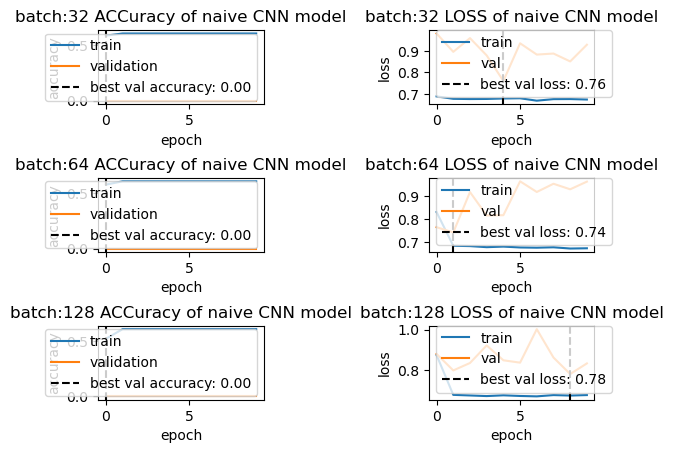

In [47]:
#Plot the results
fig, axs = plt.subplots(3, 2)
axs = axs.flatten()
for i, modl in enumerate(model_list_batch):
    plot_helper_accuracy(modl, 
                         title=f'batch:{batch_sizes[i]} ACCuracy of naive CNN model', 
                         ax=axs[i*2])
    plot_helper_loss(modl, 
                     title=f'batch:{batch_sizes[i]} LOSS of naive CNN model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


## 3. Transfer Learning

In [118]:
################################################################################
# PROCESs THE DATA (for transfer learning)
################################################################################
# Expand data to from 1 to 3 channels for ResNet50 model
X_train_expand = np.repeat(X_train, 3, -1)
X_test_expand = np.repeat(X_test, 3, -1)

# Split the data
# Train test split, shuffle = T 
X_train_expand_part, X_val, y_train_part, y_val = train_test_split(X_train_expand, y_train, test_size=0.2, shuffle= True, random_state=109)

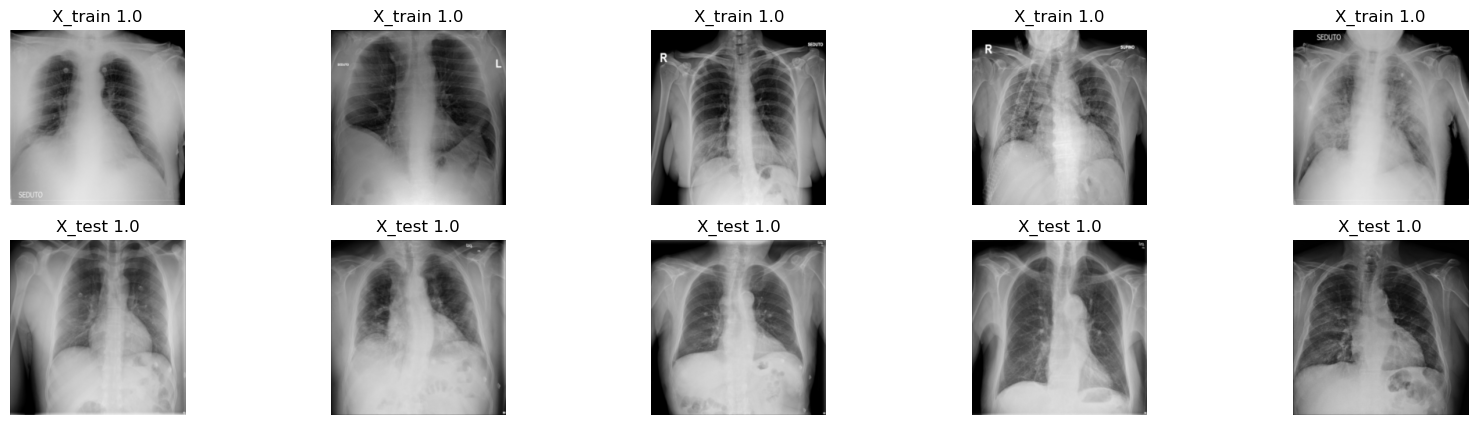

In [89]:
# Show 5 X_train and X_test expand image and its label
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in range(5):
    axs[0, i].imshow(X_train_expand[i])
    axs[0, i].set_title(f'X_train {y_train[i]}')
    axs[0, i].axis('off')
    axs[1, i].imshow(X_test_expand[i])
    axs[1, i].set_title(f'X_test {y_test[i]}')
    axs[1, i].axis('off')
plt.show()

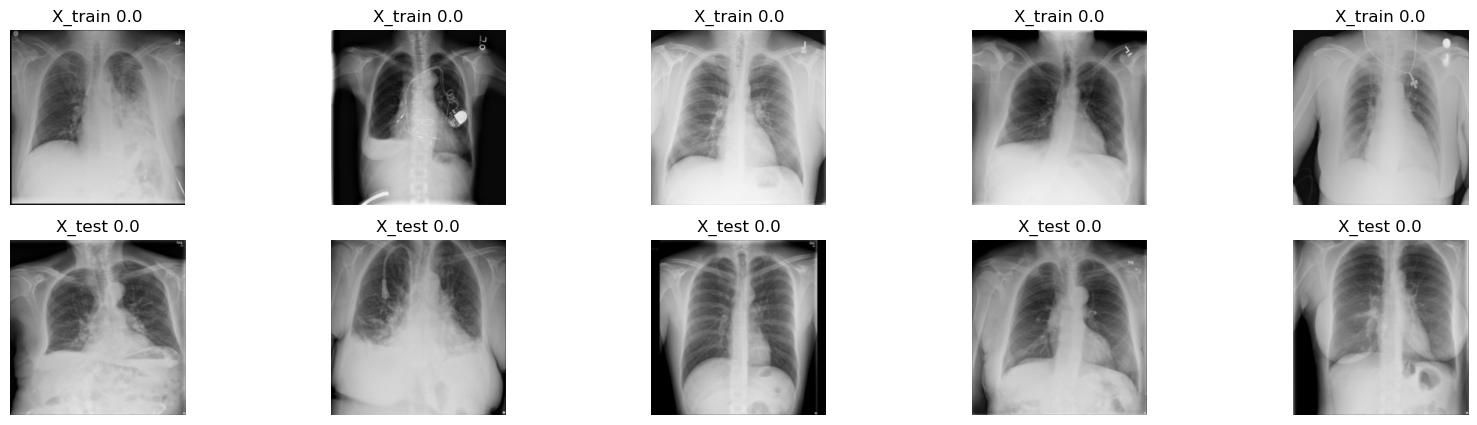

In [92]:
# Show the last 5 X_train and X_test expand image and its label
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in np.arange(1,6,1):
    axs[0, i-1].imshow(X_train_expand[-i])
    axs[0, i-1].set_title(f'X_train {y_train[-i]}')
    axs[0, i-1].axis('off')
    axs[1, i-1].imshow(X_test_expand[-i])
    axs[1, i-1].set_title(f'X_test {y_test[-i]}')
    axs[1, i-1].axis('off')
plt.show()

In [ ]:
################################################################################
# ResNet MODEL (CREATE AND COMPILE)
################################################################################
# Use ResNet50 for transfer learning 
def create_resnet_model(input_shape):
    # Use Imagenet weights
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        # unfreeze the last block of ResNet50
        if layer.name in ['conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_3_conv', 'conv5_block3_3_bn']:
            layer.trainable = True
        else:
            layer.trainable = False
    # Flatten the output of ResNet50 
    x = Flatten()(base_model.output)
    # Dense + Dropout layers 
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    # Binary classification output
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=out)
    return model

# compile the transfer learning model 
def compile_and_train_resnet_model(model, optimizer, learning_rate, batch_size, X_train, y_train, X_test, y_test, epochs):
    es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    # print(model.summary())
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[es])
    return history

In [143]:
################################################################################
# RUN ResNet
################################################################################
# Run the transfer learning model
resnet_model = create_resnet_model(input_shape=X_train_expand.shape[1:])
## Best learning rate = 1e-5 and batch_size = 32 from experimenting 
history_resnet = compile_and_train_resnet_model(model=resnet_model, optimizer=Adam, learning_rate=1e-5, batch_size=32, 
                                                X_train=X_train_expand_part, y_train=y_train_part, X_test=X_val, y_test=y_val, epochs=50) 

Epoch 1/50
25/25 [==============================] - 12s 181ms/step - loss: 0.6971 - accuracy: 0.5665 - val_loss: 0.7111 - val_accuracy: 0.4639
Epoch 2/50
25/25 [==============================] - 3s 120ms/step - loss: 0.5718 - accuracy: 0.6826 - val_loss: 0.7157 - val_accuracy: 0.4691
Epoch 3/50
25/25 [==============================] - 3s 119ms/step - loss: 0.5344 - accuracy: 0.7213 - val_loss: 0.7080 - val_accuracy: 0.4742
Epoch 4/50
25/25 [==============================] - 3s 120ms/step - loss: 0.4553 - accuracy: 0.7806 - val_loss: 0.7322 - val_accuracy: 0.4639
Epoch 5/50
25/25 [==============================] - 3s 115ms/step - loss: 0.4691 - accuracy: 0.7639 - val_loss: 0.7209 - val_accuracy: 0.4691
Epoch 6/50
25/25 [==============================] - 3s 119ms/step - loss: 0.4358 - accuracy: 0.7858 - val_loss: 0.7053 - val_accuracy: 0.4742
Epoch 7/50
25/25 [==============================] - 3s 115ms/step - loss: 0.4769 - accuracy: 0.7639 - val_loss: 0.6538 - val_accuracy: 0.5825
Epoch

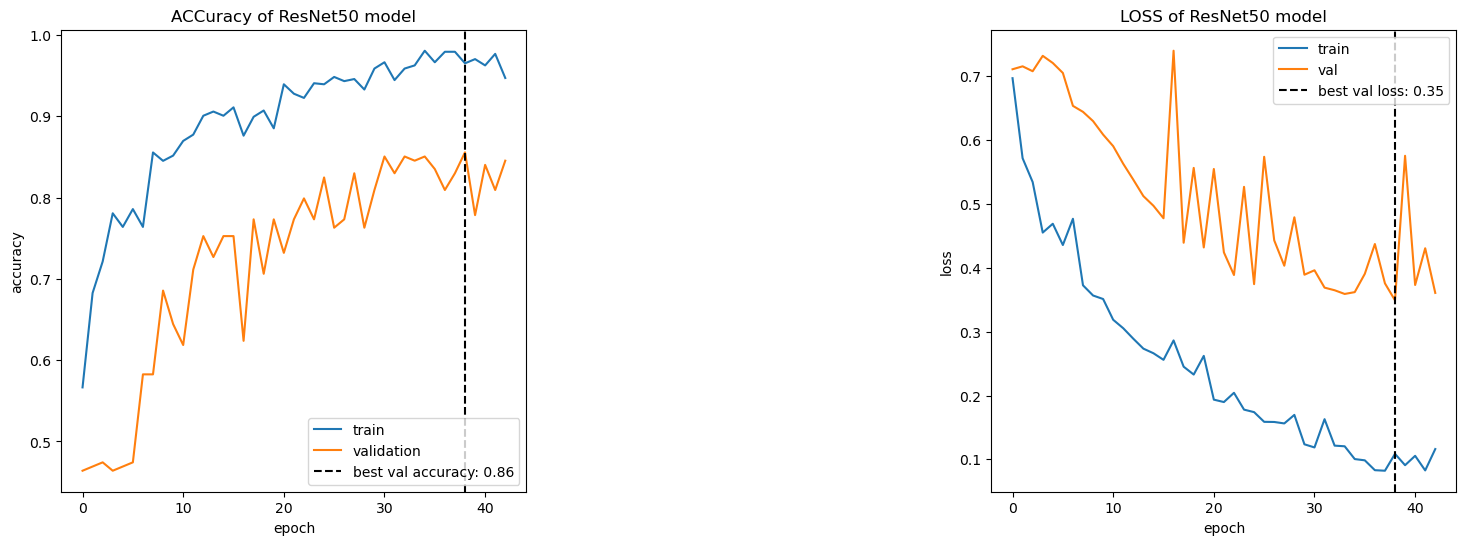

In [144]:
#Plot the results - basic ResNet
fig, axs = plt.subplots(1, 2, figsize=(18,6))
axs = axs.flatten()
plot_helper_accuracy(history_resnet, 
                         title=f'Accuracy of ResNet50 model', 
                         ax=axs[0])
plot_helper_loss(history_resnet,
                        title=f'Loss of ResNet50 model', 
                        ax=axs[1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

Epoch 1/10
25/25 [==============================] - 10s 182ms/step - loss: 1.0184 - accuracy: 0.5329 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 3s 119ms/step - loss: 0.6251 - accuracy: 0.6103 - val_loss: 0.6817 - val_accuracy: 0.5412
Epoch 3/10
25/25 [==============================] - 3s 119ms/step - loss: 0.5795 - accuracy: 0.6774 - val_loss: 0.6797 - val_accuracy: 0.6649
Epoch 4/10
25/25 [==============================] - 3s 114ms/step - loss: 0.5955 - accuracy: 0.6439 - val_loss: 0.6864 - val_accuracy: 0.4948
Epoch 5/10
25/25 [==============================] - 3s 114ms/step - loss: 0.5923 - accuracy: 0.5832 - val_loss: 0.6706 - val_accuracy: 0.5361
Epoch 6/10
25/25 [==============================] - 3s 115ms/step - loss: 0.6007 - accuracy: 0.6877 - val_loss: 0.6519 - val_accuracy: 0.6340
Epoch 7/10
25/25 [==============================] - 3s 119ms/step - loss: 0.5042 - accuracy: 0.7342 - val_loss: 0.6369 - val_accuracy: 0.7010
Epoch

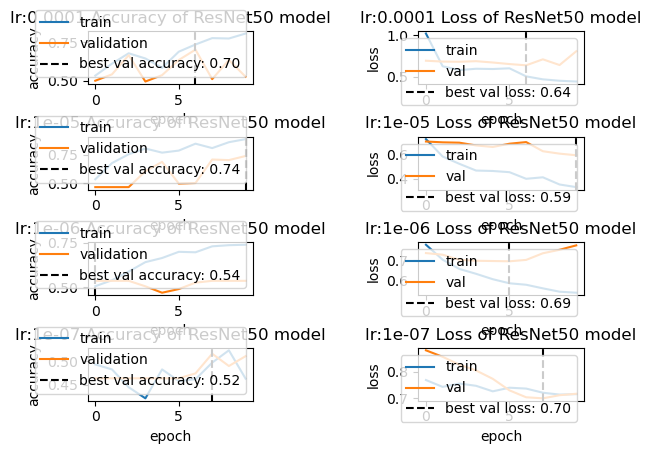

In [135]:
################################################################################
# RUN ResNet (hypeparameter tuning: learning rate)
################################################################################
# Test learning rate 
learning_rates = [1e-4, 1e-5, 1e-6, 1e-7]
model_list_lr = []
history_list_lr = []
for lr in learning_rates:
    model_lr = create_resnet_model(X_train_expand.shape[1:])
    history = compile_and_train_resnet_model(model_lr, Adam, lr, 32, X_train_expand_part, y_train_part, X_val, y_val, 10)
    model_list_lr.append(model_lr)
    history_list_lr.append(history)

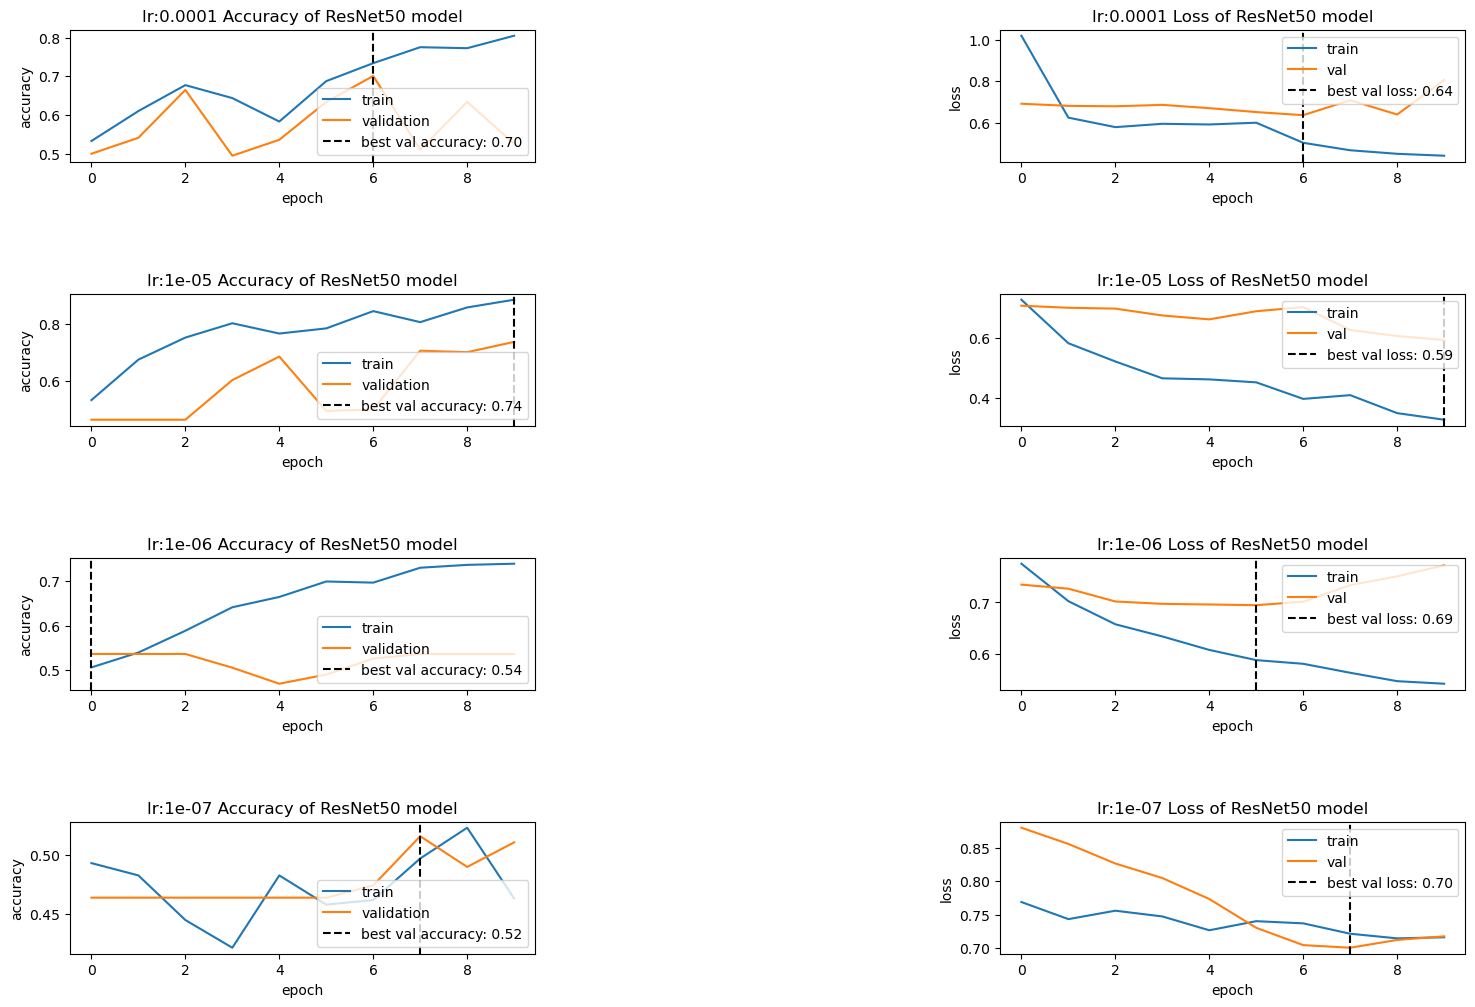

In [138]:
#plot the result - ResNet w/ learning rate
fig, axs = plt.subplots(4, 2, figsize=(18,12))
axs = axs.flatten()
for i, history in enumerate(history_list_lr):
    plot_helper_accuracy_models(history, 
                         title=f'lr:{learning_rates[i]} Accuracy of ResNet50 model', 
                         ax=axs[i*2])
    plot_helper_loss_models(history, 
                     title=f'lr:{learning_rates[i]} Loss of ResNet50 model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


learning rate = 1e-5 shows the most consistent increased in training and validation accuracy and decrease in training and testing loss

Epoch 1/10
25/25 [==============================] - 10s 182ms/step - loss: 0.7077 - accuracy: 0.5587 - val_loss: 0.7579 - val_accuracy: 0.4639
Epoch 2/10
25/25 [==============================] - 3s 120ms/step - loss: 0.5678 - accuracy: 0.7032 - val_loss: 0.7479 - val_accuracy: 0.4639
Epoch 3/10
25/25 [==============================] - 3s 120ms/step - loss: 0.5241 - accuracy: 0.7497 - val_loss: 0.7532 - val_accuracy: 0.4639
Epoch 4/10
25/25 [==============================] - 3s 119ms/step - loss: 0.4798 - accuracy: 0.7690 - val_loss: 0.7446 - val_accuracy: 0.4639
Epoch 5/10
25/25 [==============================] - 3s 120ms/step - loss: 0.4611 - accuracy: 0.7987 - val_loss: 0.7431 - val_accuracy: 0.4639
Epoch 6/10
25/25 [==============================] - 3s 120ms/step - loss: 0.4189 - accuracy: 0.8129 - val_loss: 0.7123 - val_accuracy: 0.4691
Epoch 7/10
25/25 [==============================] - 3s 115ms/step - loss: 0.4414 - accuracy: 0.7794 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch

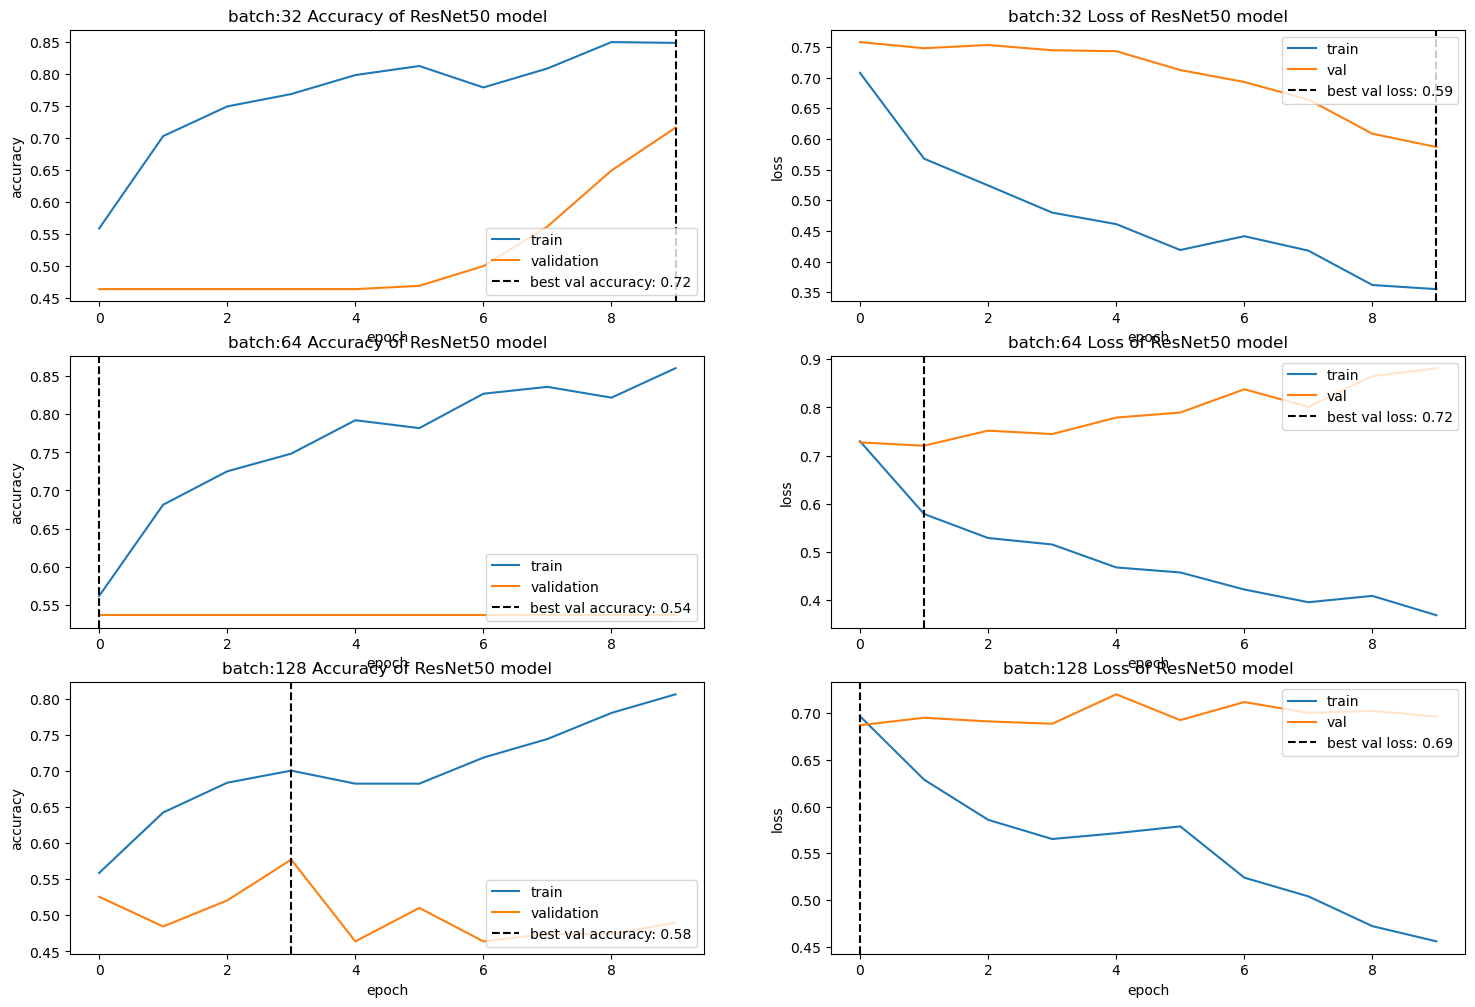

In [145]:
################################################################################
# RUN ResNet (hypeparameter tuning: batch size)
################################################################################
# Test batch size
batch_sizes = [32, 64, 128]
model_list_batch = []
history_list_batch = []
for batch in batch_sizes:
    model_batch = create_resnet_model(X_train_expand.shape[1:])
    history = compile_and_train_resnet_model(model_batch, Adam, 1e-5, batch, X_train_expand_part, y_train_part, X_val, y_val, 10) # use best learning rate
    model_list_batch.append(model_batch)
    history_list_batch.append(history)

# plot the result
fig, axs = plt.subplots(3, 2, figsize=(18,12))
axs = axs.flatten()
for i, history in enumerate(history_list_batch):
    plot_helper_accuracy_models(history, 
                         title=f'batch:{batch_sizes[i]} Accuracy of ResNet50 model', 
                         ax=axs[i*2])
    plot_helper_loss_models(history, 
                     title=f'batch:{batch_sizes[i]} Loss of ResNet50 model', 
                     ax=axs[i*2+1])

Batch size = 32 shows the most consistent increased in training and validation accuracy and decrease in training and testing loss

In [ ]:
################################################################################
# RUN ResNet (hypeparameter tuning: optimizers)
################################################################################
# Test different optimizers
optimizers = [Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax]
model_list_opt = []
history_list_opt = []
for optimizer in optimizers:
    model_opt = create_resnet_model(X_train_expand.shape[1:])
    history = compile_and_train_resnet_model(model_opt, optimizer, 1e-5, 32, X_train_expand_part, y_train_part, X_val, y_val, 10)
    model_list_opt.append(model_opt)
    history_list_opt.append(history)

#plot the results
fig, axs = plt.subplots(6, 2, figsize=(18,12))
axs = axs.flatten()
for i, history in enumerate(history_list_opt):
    plot_helper_accuracy_models(history, 
                         title=f'{optimizers[i].__name__} Accuracy of ResNet50 model', 
                         ax=axs[i*2])
    plot_helper_loss_models(history, 
                     title=f'{optimizers[i].__name__} Loss of ResNet50 model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


Adam shows the most consistent increased in training and validation accuracy and decrease in training and testing loss

In [148]:
################################################################################
# FINAL ResNet AFTER HYPERPARAMETER TUNING
## Best learning rate = 1e-5 and batch_size = 32 from experimenting 
################################################################################
# Train on whole training set and test on test set 
resnet_model = create_resnet_model(input_shape=X_train_expand.shape[1:])

history_resnet = compile_and_train_resnet_model(model=resnet_model, optimizer=Adam, learning_rate=1e-5, batch_size=32, 
                                                X_train=X_train_expand, y_train=y_train, X_test=X_test_expand, y_test=y_test, epochs=50) 

Epoch 1/50
31/31 [==============================] - 13s 241ms/step - loss: 0.6622 - accuracy: 0.6120 - val_loss: 0.8064 - val_accuracy: 0.5000
Epoch 2/50
31/31 [==============================] - 5s 171ms/step - loss: 0.5756 - accuracy: 0.6873 - val_loss: 0.8238 - val_accuracy: 0.5000
Epoch 3/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4895 - accuracy: 0.7575 - val_loss: 0.7979 - val_accuracy: 0.5000
Epoch 4/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4651 - accuracy: 0.7843 - val_loss: 0.7602 - val_accuracy: 0.5000
Epoch 5/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4286 - accuracy: 0.7988 - val_loss: 0.7278 - val_accuracy: 0.4977
Epoch 6/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4208 - accuracy: 0.8194 - val_loss: 0.7324 - val_accuracy: 0.4965
Epoch 7/50
31/31 [==============================] - 5s 173ms/step - loss: 0.4071 - accuracy: 0.8122 - val_loss: 0.7615 - val_accuracy: 0.4965
Epoch

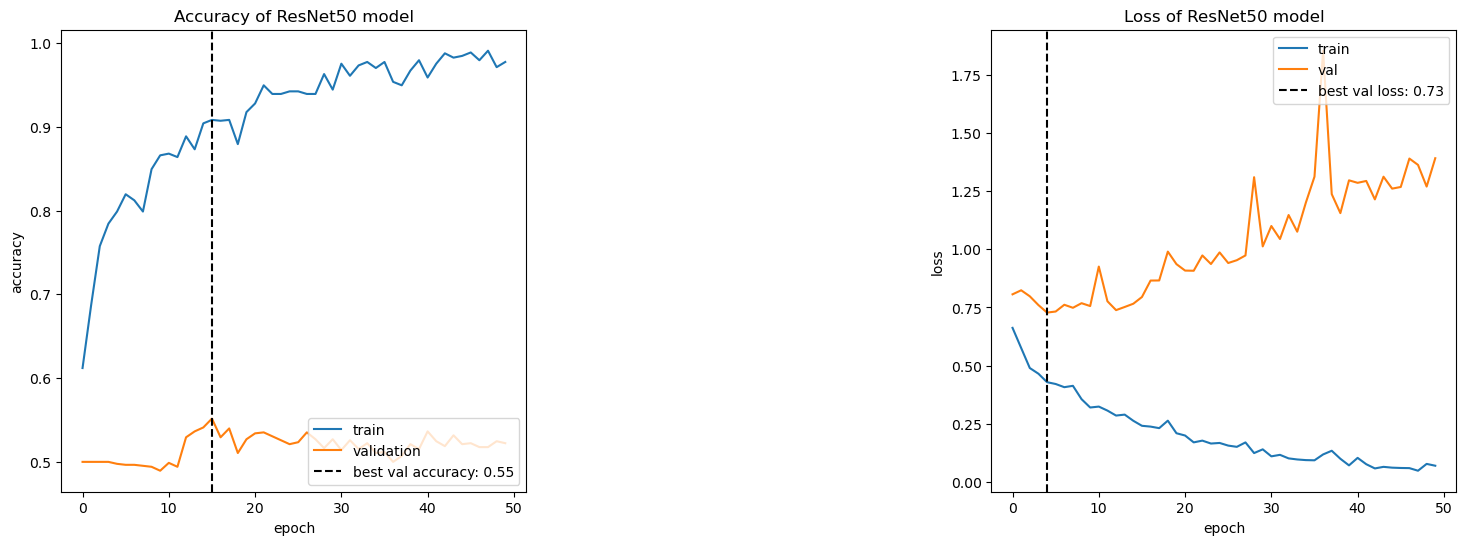

In [149]:
#plot the results
fig, axs = plt.subplots(1, 2, figsize=(18,6))
axs = axs.flatten()
plot_helper_accuracy(resnet_model, 
                         title=f'Accuracy of ResNet50 model', 
                         ax=axs[0])
plot_helper_loss(resnet_model,
                        title=f'Loss of ResNet50 model', 
                        ax=axs[1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

<a id="final_model"></a>
# 5. Final Model Pipeline Setup

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Outline steps for a pipeline for your final model, describing each component from data preprocessing to evaluation.

Document assumptions, parameter choices, and preliminary tuning considerations.